In [12]:
import os.path
import sys
sys.path.insert(0, os.path.join(os.pardir, 'sparat'))

import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from vector_similarities import compute_similarity as cs

%matplotlib inline

## Setup plotting

In [13]:
sns.set('paper', 'ticks')

column_width_pt = 243.91125
pt2inch = 1. / 72.27
column_width_inch = pt2inch * column_width_pt

## Define data to load

In [14]:
ds = [128, 256, 380, 512, 768, 1024, 2048, 3062, 4096]
df = pd.DataFrame([
        {
            'dataset': 'freeassoc',
            'symmetric': False,
            'd': 'full'
        },
        {
            'dataset': 'freeassoc',
            'symmetric': True,
            'd': 'full',
        },
        {
            'dataset': 'google',
            'symmetric': True,
            'd': 'full',
        }
    ] + [
        {
            'dataset': dataset,
            'symmetric': True,
            'd': d
        } for dataset, d in itertools.product(['freeassoc', 'google'], ds)
    ])

## Load and compute data

In [15]:
def datafile_for_row(row):
    filename = [row['dataset']]
    if row['symmetric']:
        filename.append('symmetric')
    else:
        filename.append('asymmetric')
    if row['d'] != 'full':
        filename.append('svd_factorize_5018w')
        filename.append(str(row['d']) + 'd')
    return '_'.join(filename)

In [16]:
def compute_tops(row, tops):
    _, _, targets = cs.compute_similarity(datafile_for_row(row))
    return pd.Series(np.sum(targets[:, None] < np.asarray(tops)[None, :], axis=0), index=tops)

In [17]:
tops = [1, 2, 3, 5, 10]
df = df.join(df.apply(compute_tops, args=(tops,), axis=1))
df['num_d'] = pd.to_numeric(df['d'], 'coerce')

## Plot

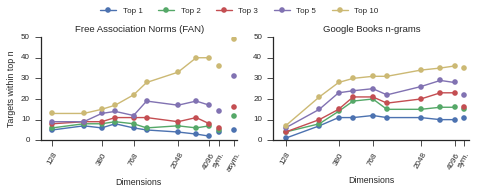

In [18]:
groups = df.dropna().groupby('dataset')
titles = {'freeassoc': 'Free Association Norms (FAN)', 'google': 'Google Books n-grams'}
colors = sns.color_palette(n_colors=len(tops))
full_d = 5018
asym_d = 7000
end_spacing = 500

fig = plt.figure(figsize=(2 * column_width_inch, 0.8 * column_width_inch))
ax = None
for i, (n, g) in enumerate(groups):
    ax = fig.add_subplot(1, len(groups), i + 1, sharey=ax)
    for j, t in enumerate(tops):
        ax.plot(g['d'], g[t], 'o-', label='Top ' + str(t), c=colors[j])
        full = df.query('d == "full" and symmetric == True and dataset == ' + repr(n))
        ax.plot(full_d, full[t], 'o-', c=colors[j])
        
        if n == 'freeassoc':
            asym = df.query('d == "full" and symmetric == False and dataset == ' + repr(n))
            ax.plot(asym_d, asym[t], 'o-', c=colors[j])
    
    ax.semilogx()
    ax.set_title(titles[n])
    ax.set_xlabel('Dimensions')
    
    if n == 'freeassoc':
        xlim = asym_d + end_spacing
        add_ticks = [full_d, asym_d]
        add_labels = ['sym.', 'asym.']
    else:
        xlim = full_d + end_spacing
        add_ticks = [full_d]
        add_labels = ['sym.']
    
    ax.set_xlim(right=xlim)
    ax.set_xticks([], minor=True)
    ticks = ds[::2]
    ax.set_xticks(ticks + add_ticks)
    ax.set_xticklabels([str(tick) for tick in ticks] + add_labels, rotation=60)
    
fig.axes[0].set_ylabel('Targets within top n')
fig.legend(*ax.get_legend_handles_labels(), loc='upper center', ncol=len(tops))
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=0.825)  # Tight layout doesn't seem to take figlegend into account

In [19]:
fig.savefig(os.path.join(os.pardir, 'txt', 'cogsci-paper', 'figures', 'svd.pdf'))

## Table

In [20]:
table_df = df.query('d == "full"')
table_df

,d,dataset,symmetric,1,2,3,5,10,num_d
0,full,freeassoc,False,5,12,16,31,49,NaN
1,full,freeassoc,True,4,5,6,14,36,NaN
2,full,google,True,11,15,16,22,35,NaN


In [21]:
def name_from_row(row):
    name = {'freeassoc': r"\fan", 'google': r"\ng"}[row['dataset']]
    if row['symmetric']:
        name = name + 'sym'
    else:
        name = name + 'asym'
    return name + '{}'

row_template = r'{dataset} & {t1} & {t2} & {t3} & {t5} & {t10} \\'
table = [
    r'\begin{tabular}{lrrrrr}'
    r'\toprule',
    r'& \multicolumn{5}{c}{Within top} \\',
    r'\cmidrule{2-6}',
    row_template.format(dataset="Association matrix", t1=1, t2=2, t3=3, t5=5, t10=10),
    r'\midrule']
for i, row in table_df.iterrows():
    table.append(row_template.format(
        dataset=name_from_row(row), t1=row[1], t2=row[2], t3=row[3], t5=row[5], t10=row[10]))
table.append(r'\bottomrule')
table.append(r'\end{tabular}')

In [22]:
with open(os.path.join(os.pardir, 'txt', 'cogsci-paper', 'tables', 'svd.tex'), 'wt') as f:
    f.write(os.linesep.join(table))
    f.write(os.linesep)